# Biodiversity Intactness Index change in Phoenix, AZ

Link to repo: https://github.com/leirubinstein/eds220-final-project (more content available here!)

## About

**Purpose:**



**Highlights:**



**Dataset Descriptions**: 

Biodiversity Intactness Index (BII) Time Series Access the io-biodiversity collection from the Microsoft Planetary Computer STAC catalog. Use the 2017 and 2020 rasters covering the Phoenix subdivision. For the bounding box, use the following coordinates:
[-112.826843, 32.974108, -111.184387, 33.863574]

Phoenix Subdivision Shapefile Download the Phoenix subdivision polygon from the Census County Subdivision shapefiles for Arizona.

**References:**

- https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
from pystac_client import Client
import planetary_computer 
from IPython.display import Image
from shapely.geometry import box
import xarray as xr
import contextily as cx

In [2]:
pwd

'/Users/rubinstein/MEDS/EDS-220-ENV-DATASETS/eds220-final-project'

In [3]:
# Import Phoenix subdivision shapefile
root = os.path.join('/','Users', 'rubinstein', 'MEDS', 'EDS-220-ENV-DATASETS', 'eds220-final-project', 'data')
az = gpd.read_file(os.path.join(root,
                                     'tl_2022_04_cousub',
                                     'tl_2022_04_cousub.shp'))
# Reproject CRS to EPSG:4326
az = az.to_crs('epsg:4326')

# Filter to Phoenix subdivision
phoenix = az[az['NAME'] == 'Phoenix']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


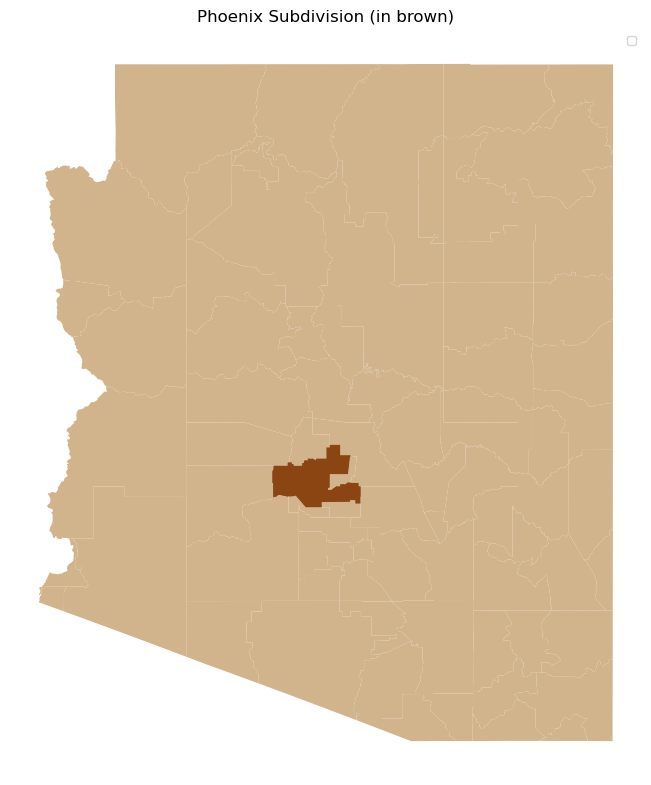

In [4]:
fig, ax = plt.subplots(figsize=(10,8))

ax.axis('off')

az.plot(ax=ax, color='tan')

phoenix.plot(ax=ax, color='saddlebrown')

ax.legend(fontsize='small')
plt.tight_layout()
plt.subplots_adjust(bottom=0.05)

ax.set_title('Phoenix Subdivision (in brown)')

# plt.figtext(0.01, 0.015, "Data: NASA Landsat & CalFire", ha="left", fontsize=10)

plt.show()

In [5]:
# Temporal range of interest during growth of development
time_range = '2017-01-01/2021-01-01'

In [6]:
# Create bounding box for search
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

In [7]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Search MPC catalog
search = catalog.search(collections = ['io-biodiversity'],
                        bbox = bbox,
                        datetime = time_range
                       )

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


In [8]:
# Get the 2017 and 2020 BII items
item_2020 = items[0]
item_2017 = items[3]
item_2020

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

In [9]:
# Access raster data from item
io_bio2020 = rioxr.open_rasterio(item_2020.assets['data'].href)

In [10]:
io_bio2020 = (io_bio2020.rio.clip_box(*phoenix.total_bounds)
                 .rio.clip(phoenix.geometry)
                 )

io_bio2020 = io_bio2020.squeeze().drop_vars('band')                          

In [11]:
print("Min value:", io_bio2020.min().values)
print("Max value:", io_bio2020.max().values)
print("Number of valid pixels:", io_bio2020.count().values)

Min value: 0.08015034
Max value: 0.8802183
Number of valid pixels: 338700


In [12]:
high_bii_2020 = (io_bio2020 >= 0.75)

(-112.47004683159909,
 -111.58071470032075,
 33.290277300227984,
 33.81399511086966)

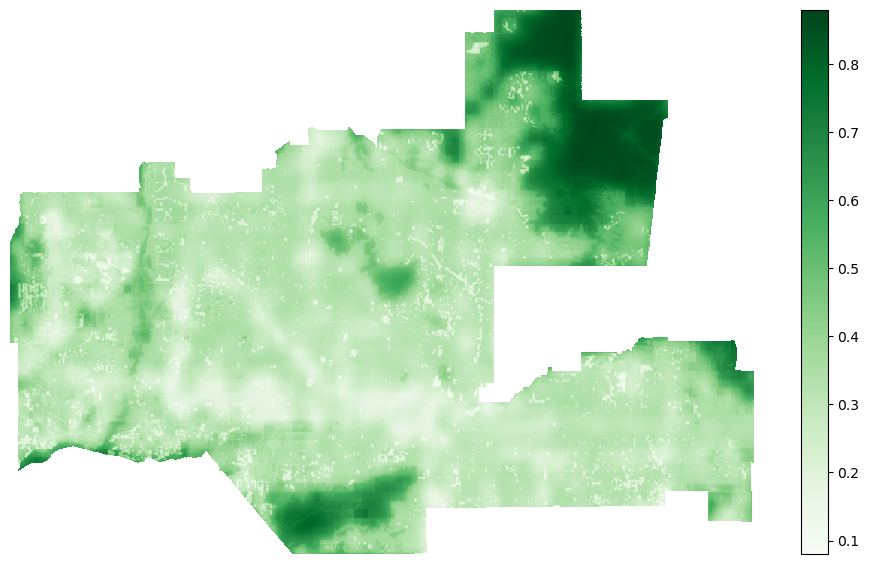

In [24]:
# Plot raster with correct ratio
aspect=io_bio2020.rio.width/io_bio2020.rio.height

fig, ax = plt.subplots(figsize=(12, 12/aspect))



io_bio2020.plot(ax=ax,
                cmap='Greens',
                add_labels=False,
                add_colorbar=True)

ax.axis('off')

### Calculate the percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 & 2020